# Remote Sensing with terra

## Steps
- Define a study area  
- Search Landsat 8 record with luna
- Get Landsat 8 data from AWS: in CoG
- Do whatever we want!

In [83]:
#setup copy
# following line controls the size of plot output in ipython
options(repr.plot.width=16, repr.plot.height=10)

In [85]:
#load packages and 
library(terra)
library(luna)

# check if it worked
print(1+1)

[1] 2


In [86]:
# search image
product <- "Landsat_8_OLI_TIRS_C1"
sdate <- "2019-05-01" 
edate <- "2019-05-30"
area <- c(90.3, 90.6, 24.5, 24.8)
dir <- getwd()
f <- getLandsat(product, start_date=sdate, end_date=edate, aoi=area, download=FALSE, path=dir)

In [87]:
# list of files
f[1:10]

[1] "LC08_L1TP_137043_20190515_20190521_01_T1_B1.TIF" 
 [2] "LC08_L1TP_137043_20190515_20190521_01_T1_B2.TIF" 
 [3] "LC08_L1TP_137043_20190515_20190521_01_T1_B3.TIF" 
 [4] "LC08_L1TP_137043_20190515_20190521_01_T1_B4.TIF" 
 [5] "LC08_L1TP_137043_20190515_20190521_01_T1_B5.TIF" 
 [6] "LC08_L1TP_137043_20190515_20190521_01_T1_B6.TIF" 
 [7] "LC08_L1TP_137043_20190515_20190521_01_T1_B7.TIF" 
 [8] "LC08_L1TP_137043_20190515_20190521_01_T1_B8.TIF" 
 [9] "LC08_L1TP_137043_20190515_20190521_01_T1_B9.TIF" 
[10] "LC08_L1TP_137043_20190515_20190521_01_T1_B10.TIF"

In [5]:
# a simple function to return COG url: copy
getCOG <- function(fu){
  burl <- "http://landsat-pds.s3.amazonaws.com/c1/L8"
  pr <- strsplit(fu, "_")[[1]][3]
  path <- substr(pr,1,3)
  row <- substr(pr,4,6)
  imageID <- paste0(unlist(strsplit(fu, "_")) [1:7], collapse="_")
  fp <- file.path(burl, path, row, imageID, fu)
  turl <- file.path("/vsicurl", fp)  
  return(turl)  
}

In [6]:
# url for downloading one single file
u1 <- getCOG(f[1])
print(u1)

[1] "/vsicurl/http://landsat-pds.s3.amazonaws.com/c1/L8/137/043/LC08_L1TP_137043_20190515_20190521_01_T1/LC08_L1TP_137043_20190515_20190521_01_T1_B1.TIF"


In [7]:
# read one file from the url 
r1 <- rast(u1)

In [8]:
# try reading 4 bands: NIR (B5), RED(B4), GREEN(B3), BLUE(B2)
f1 <- grep("B5|B4|B3|B2", f, value=TRUE)
print(f1)

[1] "LC08_L1TP_137043_20190515_20190521_01_T1_B2.TIF"
[2] "LC08_L1TP_137043_20190515_20190521_01_T1_B3.TIF"
[3] "LC08_L1TP_137043_20190515_20190521_01_T1_B4.TIF"
[4] "LC08_L1TP_137043_20190515_20190521_01_T1_B5.TIF"


In [9]:
# COG url for 3 files
fu1 <- sapply(f1, getCOG)
print(fu1[1])

                                                                                                      LC08_L1TP_137043_20190515_20190521_01_T1_B2.TIF 
"/vsicurl/http://landsat-pds.s3.amazonaws.com/c1/L8/137/043/LC08_L1TP_137043_20190515_20190521_01_T1/LC08_L1TP_137043_20190515_20190521_01_T1_B2.TIF" 


In [10]:
# read all three bands
rr <- rast(fu1)
rr

class       : SpatRaster 
dimensions  : 7861, 7711, 4  (nrow, ncol, nlyr)
resolution  : 30, 30  (x, y)
extent      : 155985, 387315, 2598885, 2834715  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=utm +zone=46 +datum=WGS84 +units=m +no_defs 
sources     : LC08_L1TP_137043_20190515_20190521_01_T1_B2.TIF  
              LC08_L1TP_137043_20190515_20190521_01_T1_B3.TIF  
              LC08_L1TP_137043_20190515_20190521_01_T1_B4.TIF  
              ... and 1 more source(s)
names       : LC08_L1~1_T1_B2, LC08_L1~1_T1_B3, LC08_L1~1_T1_B4, LC08_L1~1_T1_B5 

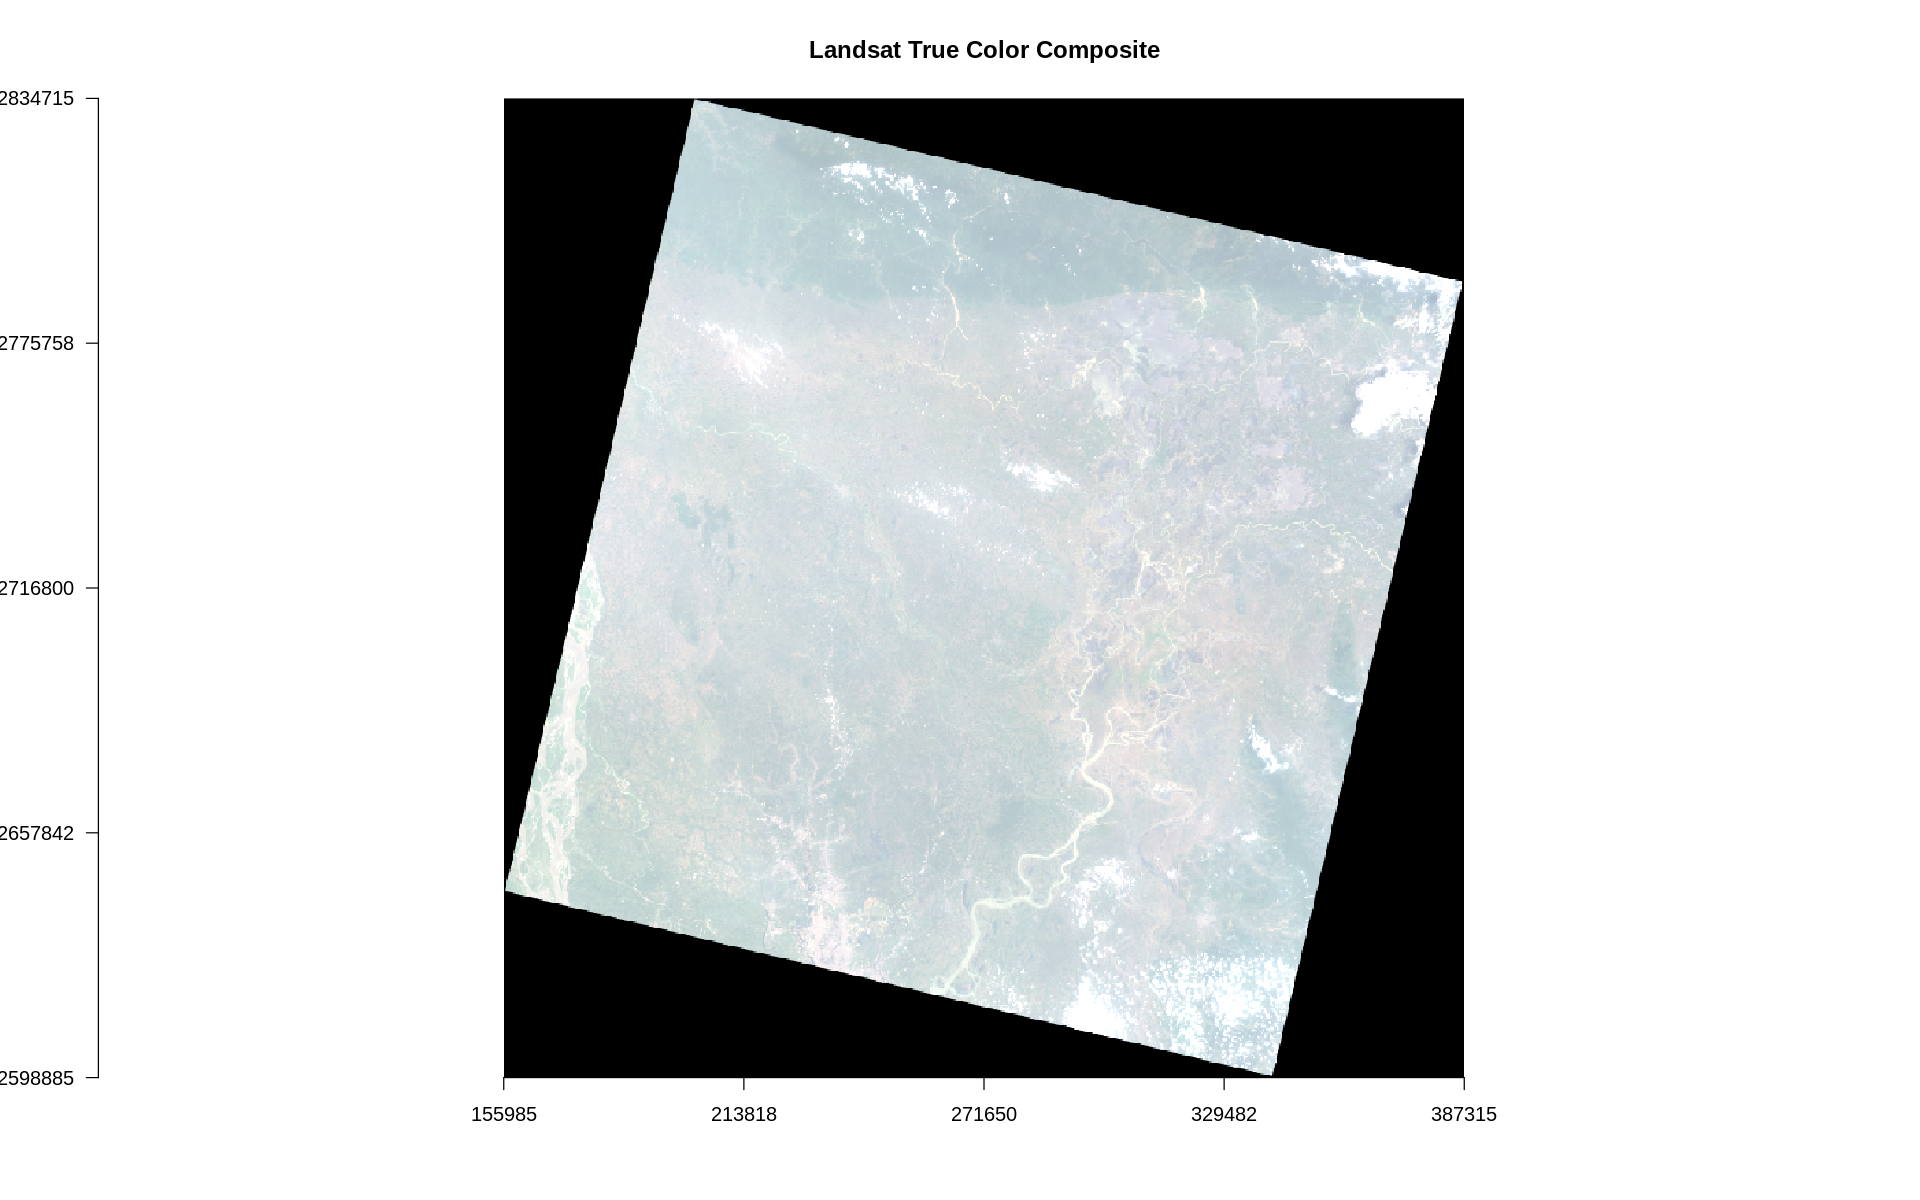

In [11]:
# plot bands
# it takes some time
plotRGB(rr, axes = TRUE, r=3, g=2, b=1, stretch = "lin", main = "Landsat True Color Composite")

In [12]:
# the above example takes some time
xmin <- 271650
ymin <- 2717000

e <- ext(c(xmin, xmin+10000, ymin, ymin + 10000))
rrs <- crop(rr,e)

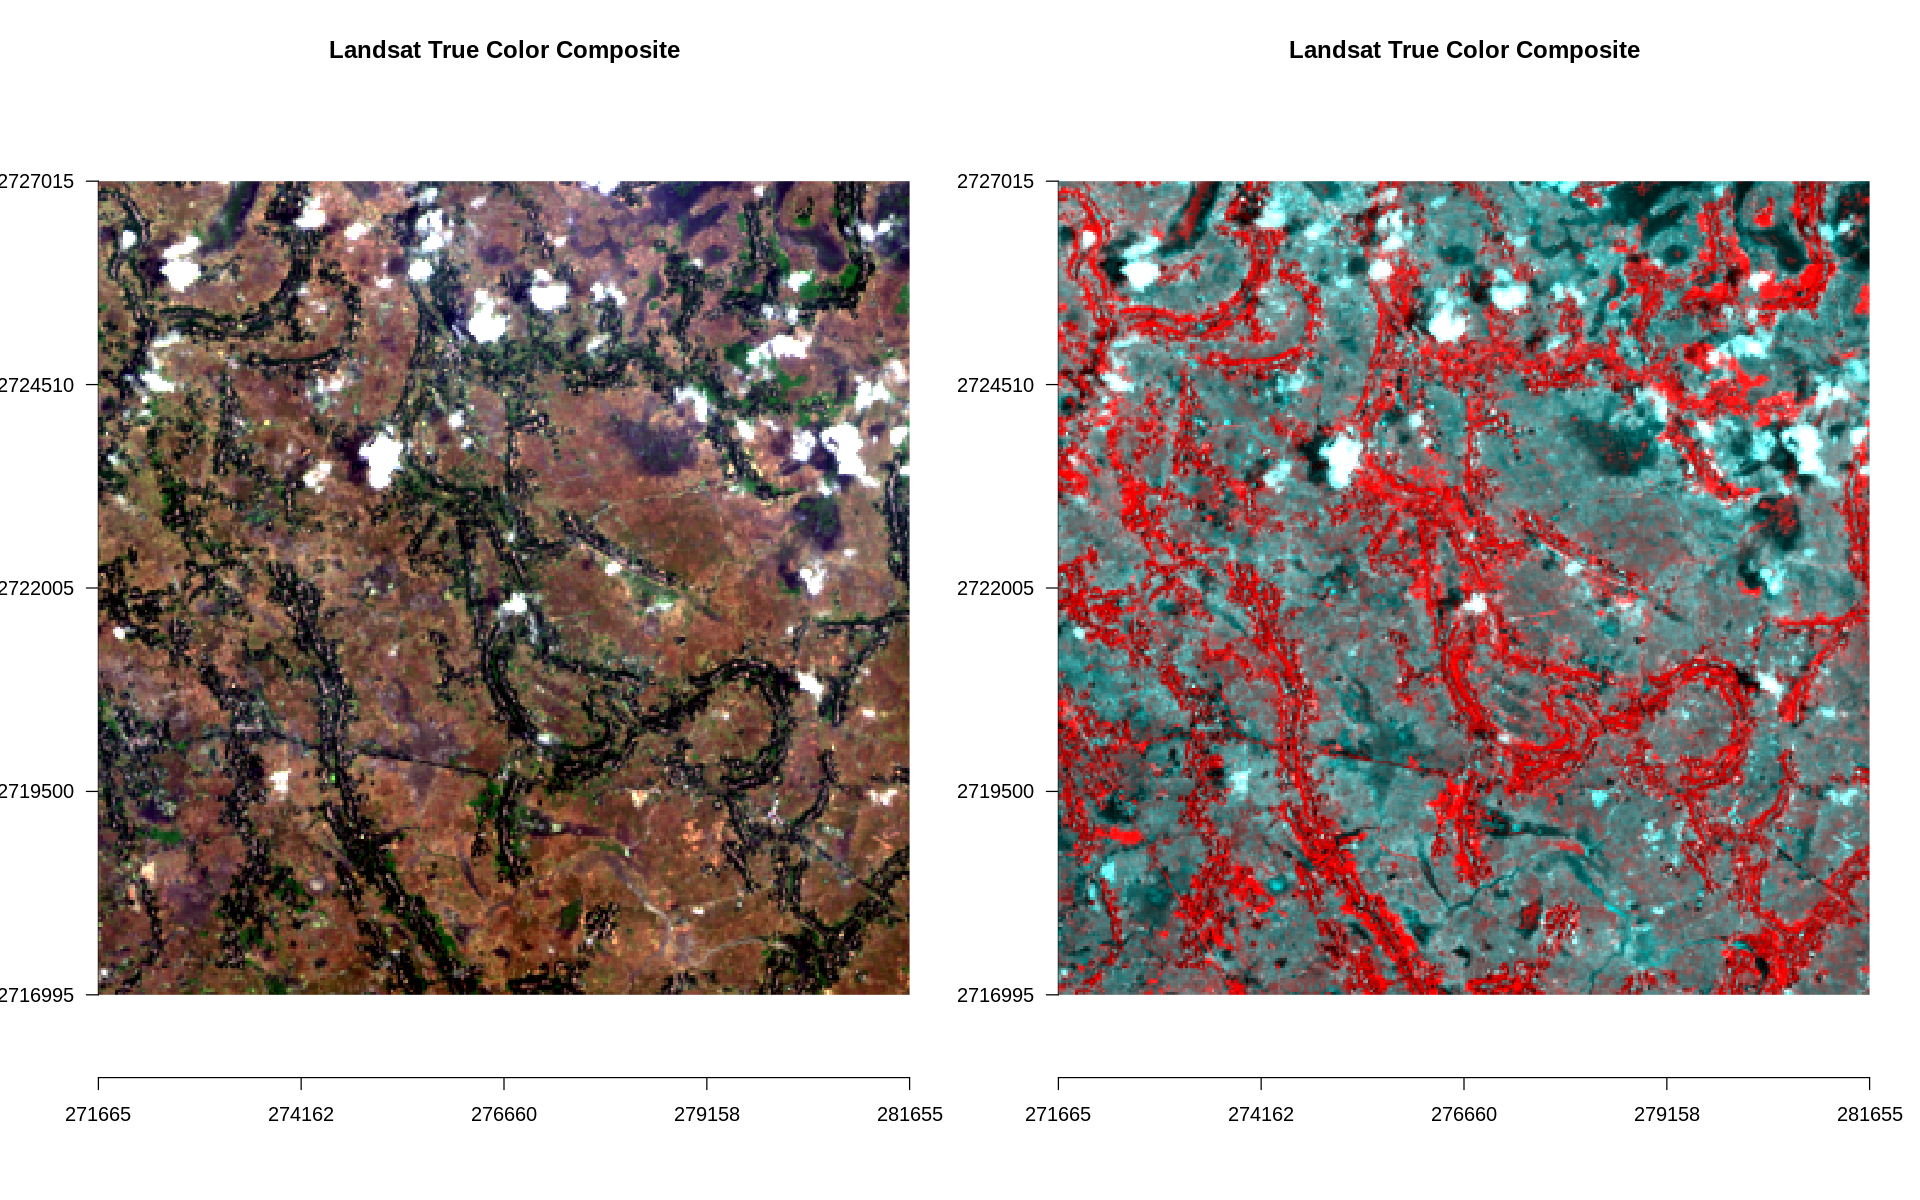

In [13]:
# plot results side-by-side
par(mfrow=c(1,2))
plotRGB(rrs, axes = TRUE, r=3, g=2, b=1, stretch = "lin", main = "Landsat True Color Composite")
plotRGB(rrs, axes = TRUE, r=4, g=3, b=3, stretch = "lin", main = "Landsat True Color Composite")

In [17]:
# compute vegetation indices
vi <- function(img, k, i) {
  bk <- img[[k]]
  bi <- img[[i]]
  vi <- (bk - bi) / (bk + bi)
  return(vi)
}

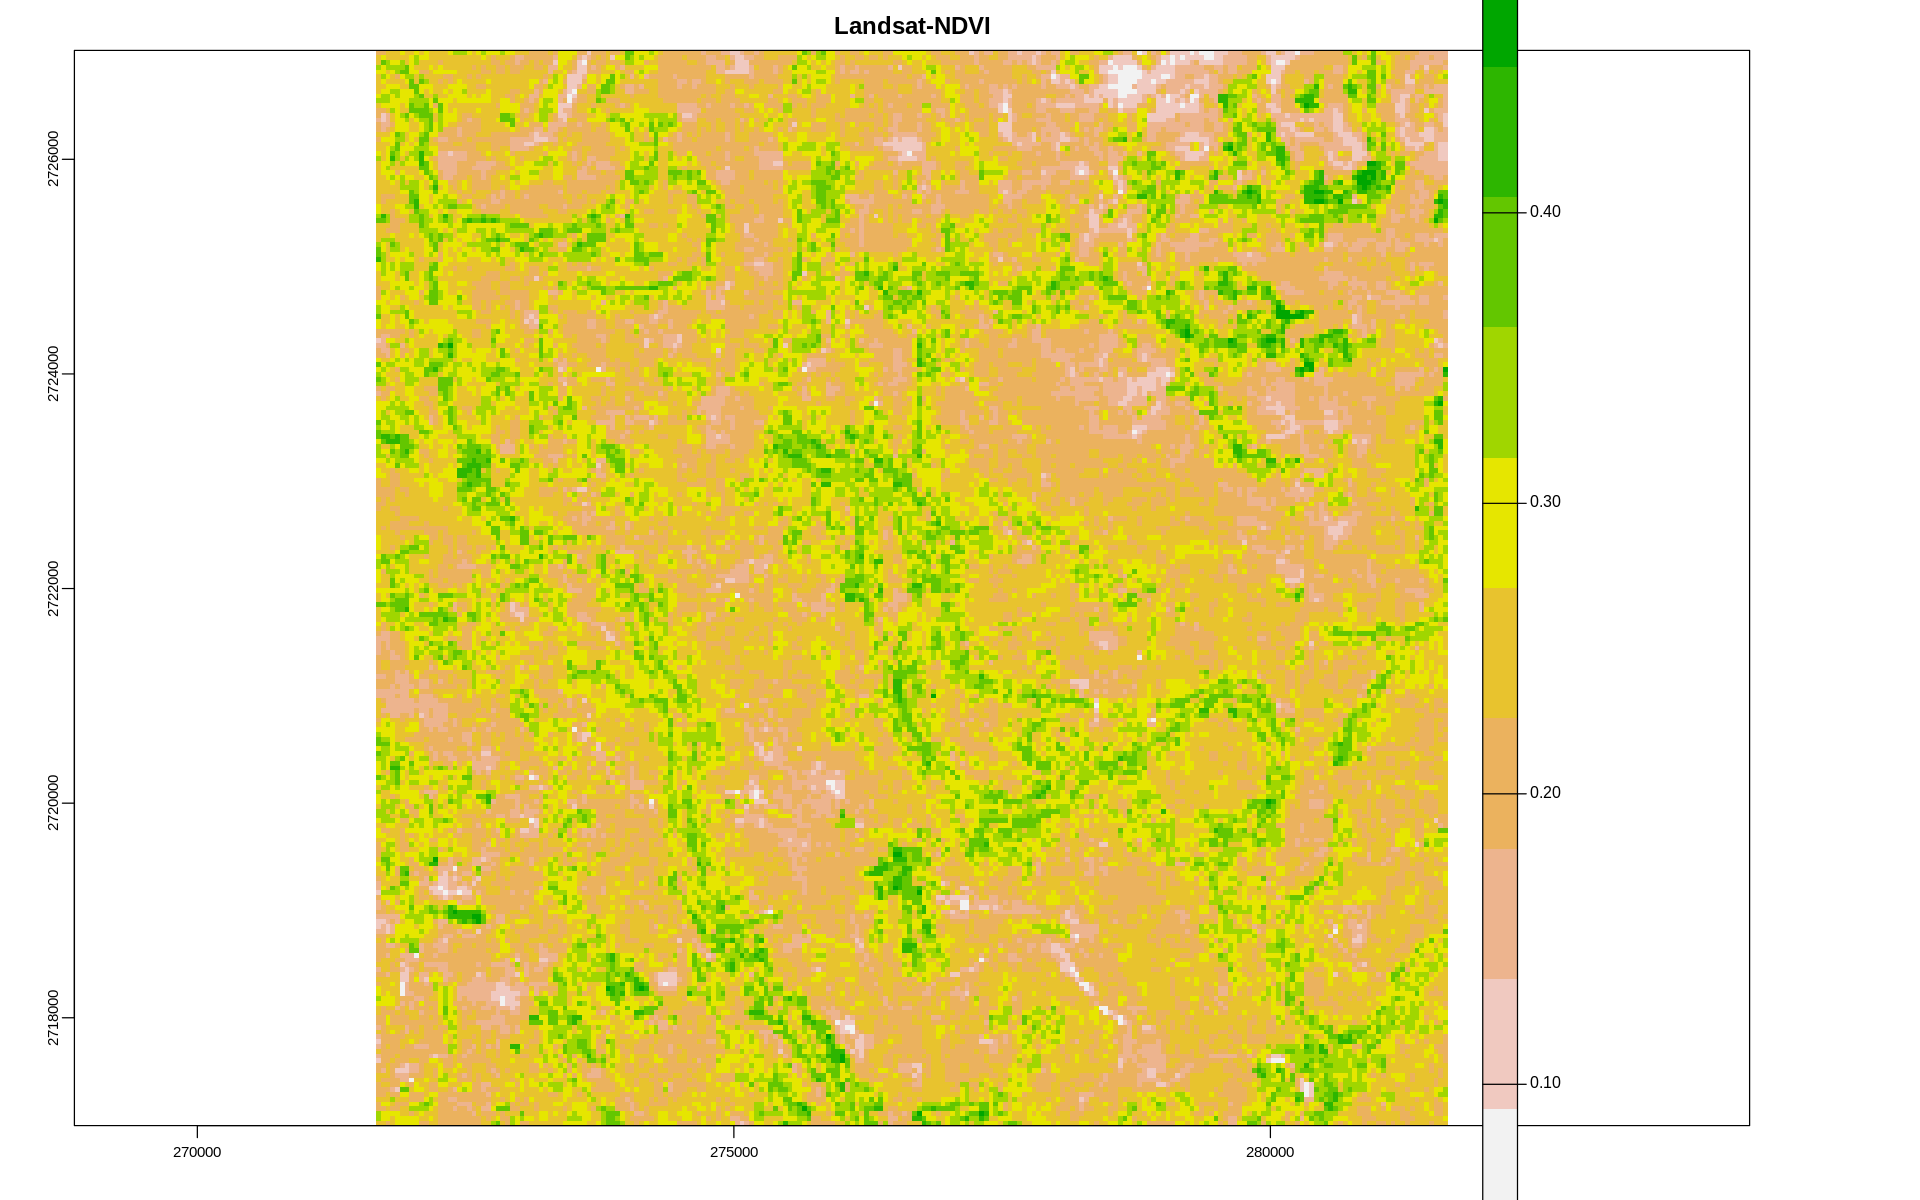

In [19]:
# we have 4 band spatraster; last two bands are red and nir
ndvi <- vi(rrs, 4, 3)
plot(ndvi, col=rev(terrain.colors(10)), main = "Landsat-NDVI")

In [24]:
# what if I need them in raster stack or brick
library(raster)
nx <- raster(ndvi)
nx

class      : RasterLayer 
dimensions : 334, 333, 111222  (nrow, ncol, ncell)
resolution : 30, 30  (x, y)
extent     : 271665, 281655, 2716995, 2727015  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=46 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : LC08_L1TP_137043_20190515_20190521_01_T1_B5 
values     : 0.01502859, 0.4952506  (min, max)


In [31]:
# what if we need a package
install.packages("leaflet.opacity")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded ellps WGS 84 in Proj4 definition: +proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs +type=crs”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum World Geodetic System 1984 in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded ellps WGS 84 in Proj4 definition: +proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs +type=crs”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum World Geodetic System 1984 in Proj4 definition”


HTML widgets cannot be represented in plain text (need html)
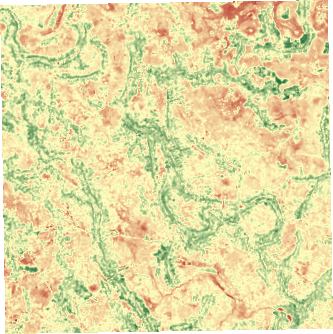

In [35]:
# interactive mapping?
library(leaflet)
library(leaflet.opacity)
pal <- colorNumeric(c("#a50026", "#ffffbf", "#006837"), values(nx),
  na.color = "transparent")

leaflet() %>% addTiles() %>%
  addProviderTiles(providers$Esri.WorldImagery) %>%
  addRasterImage(nx, colors = pal, layerId = "ndvi") %>%
  addOpacitySlider(layerId = "ndvi") %>%
  addLegend(pal = pal, values = values(nx),
    title = "NDVI")

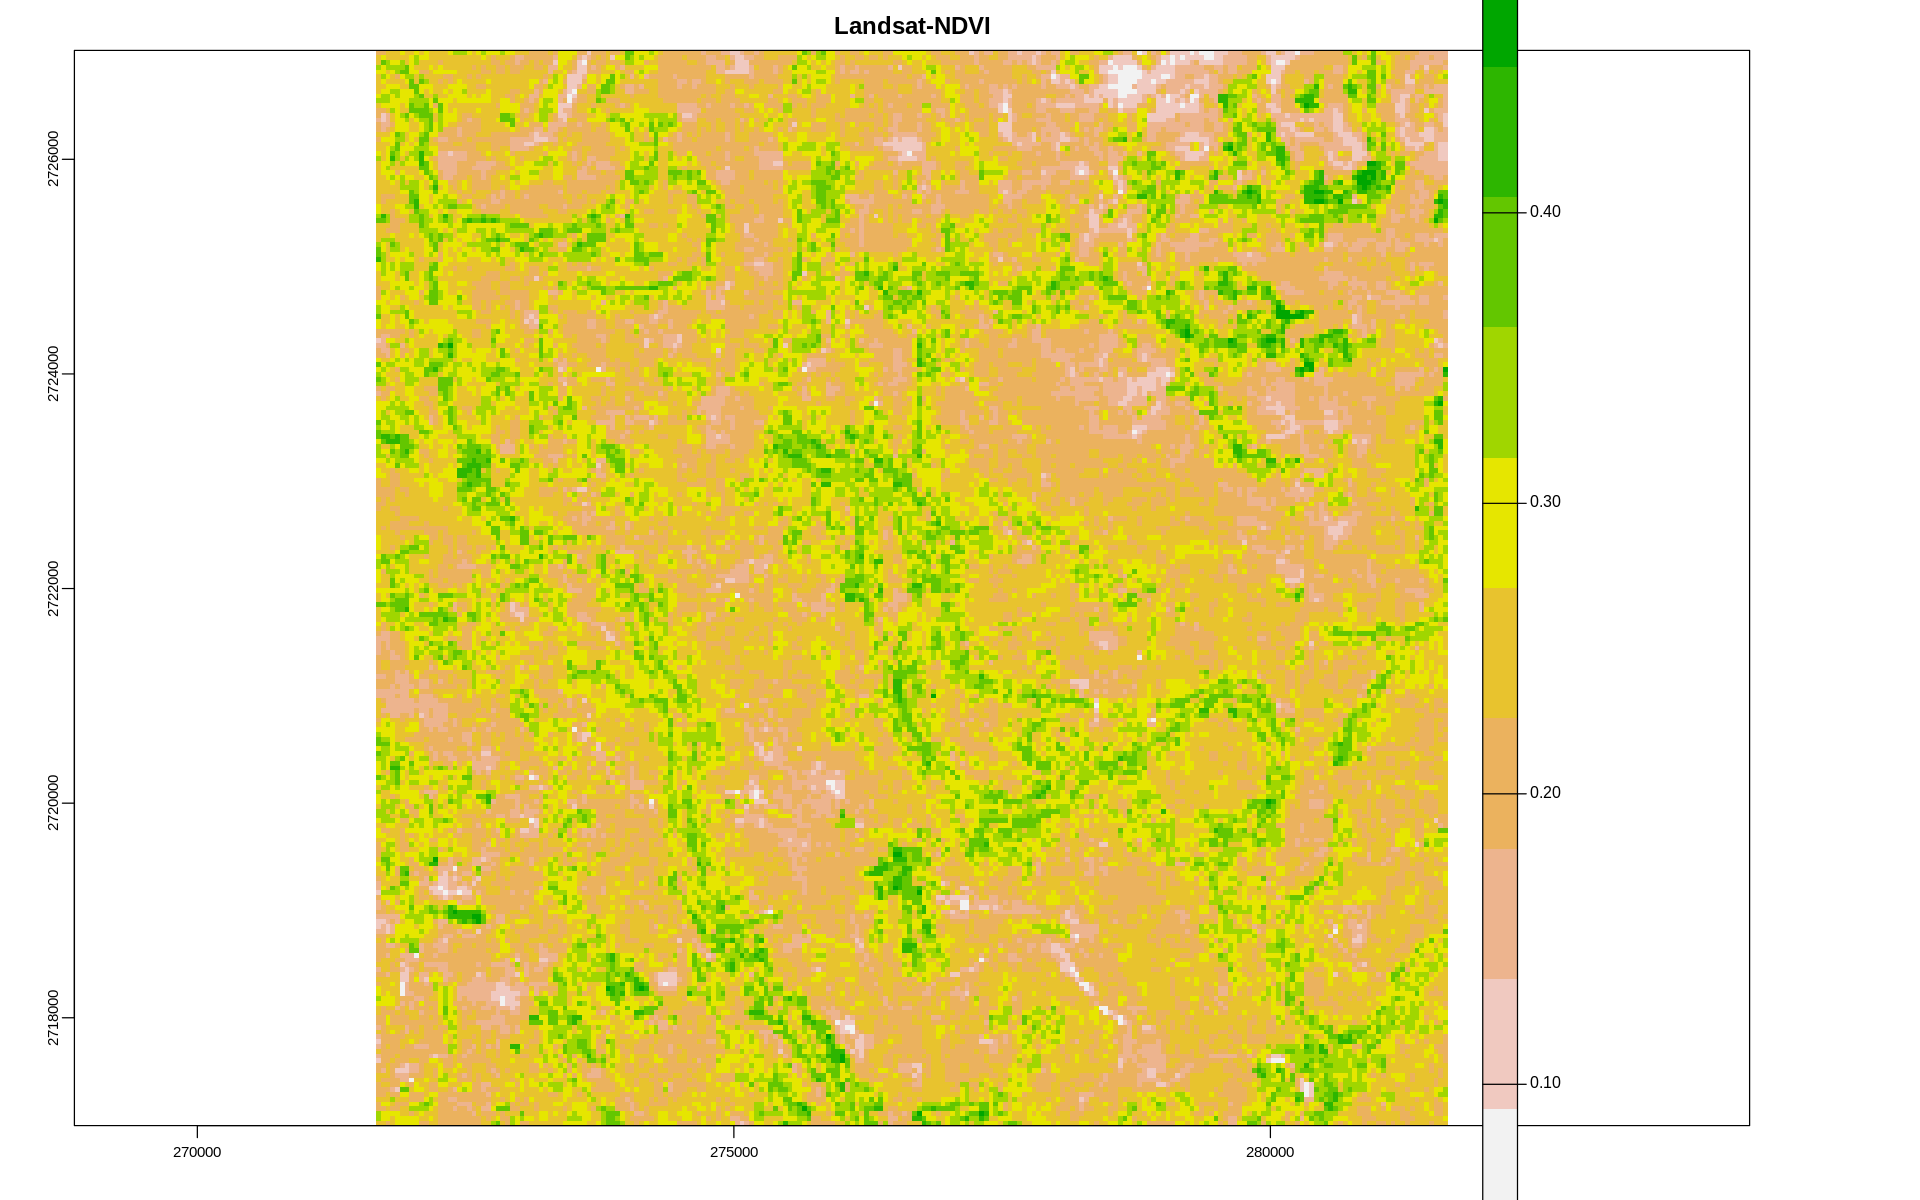

In [37]:
# alternative way to compute the NDVI
# Write a general function that can compute 2-layer NDVI type indices
vi2 <- function(x, y) {
    (x - y) / (x + y)
}

# subset bands
nir <- rrs[[4]]
red <- rrs[[3]]
ndvi2 <- lapp(c(nir, red), fun = vi2)

# or in one line
ndvi2 <- lapp(rrs[[4:3]], fun=vi2)
plot(ndvi2, col=rev(terrain.colors(10)), main="Landsat-NDVI")

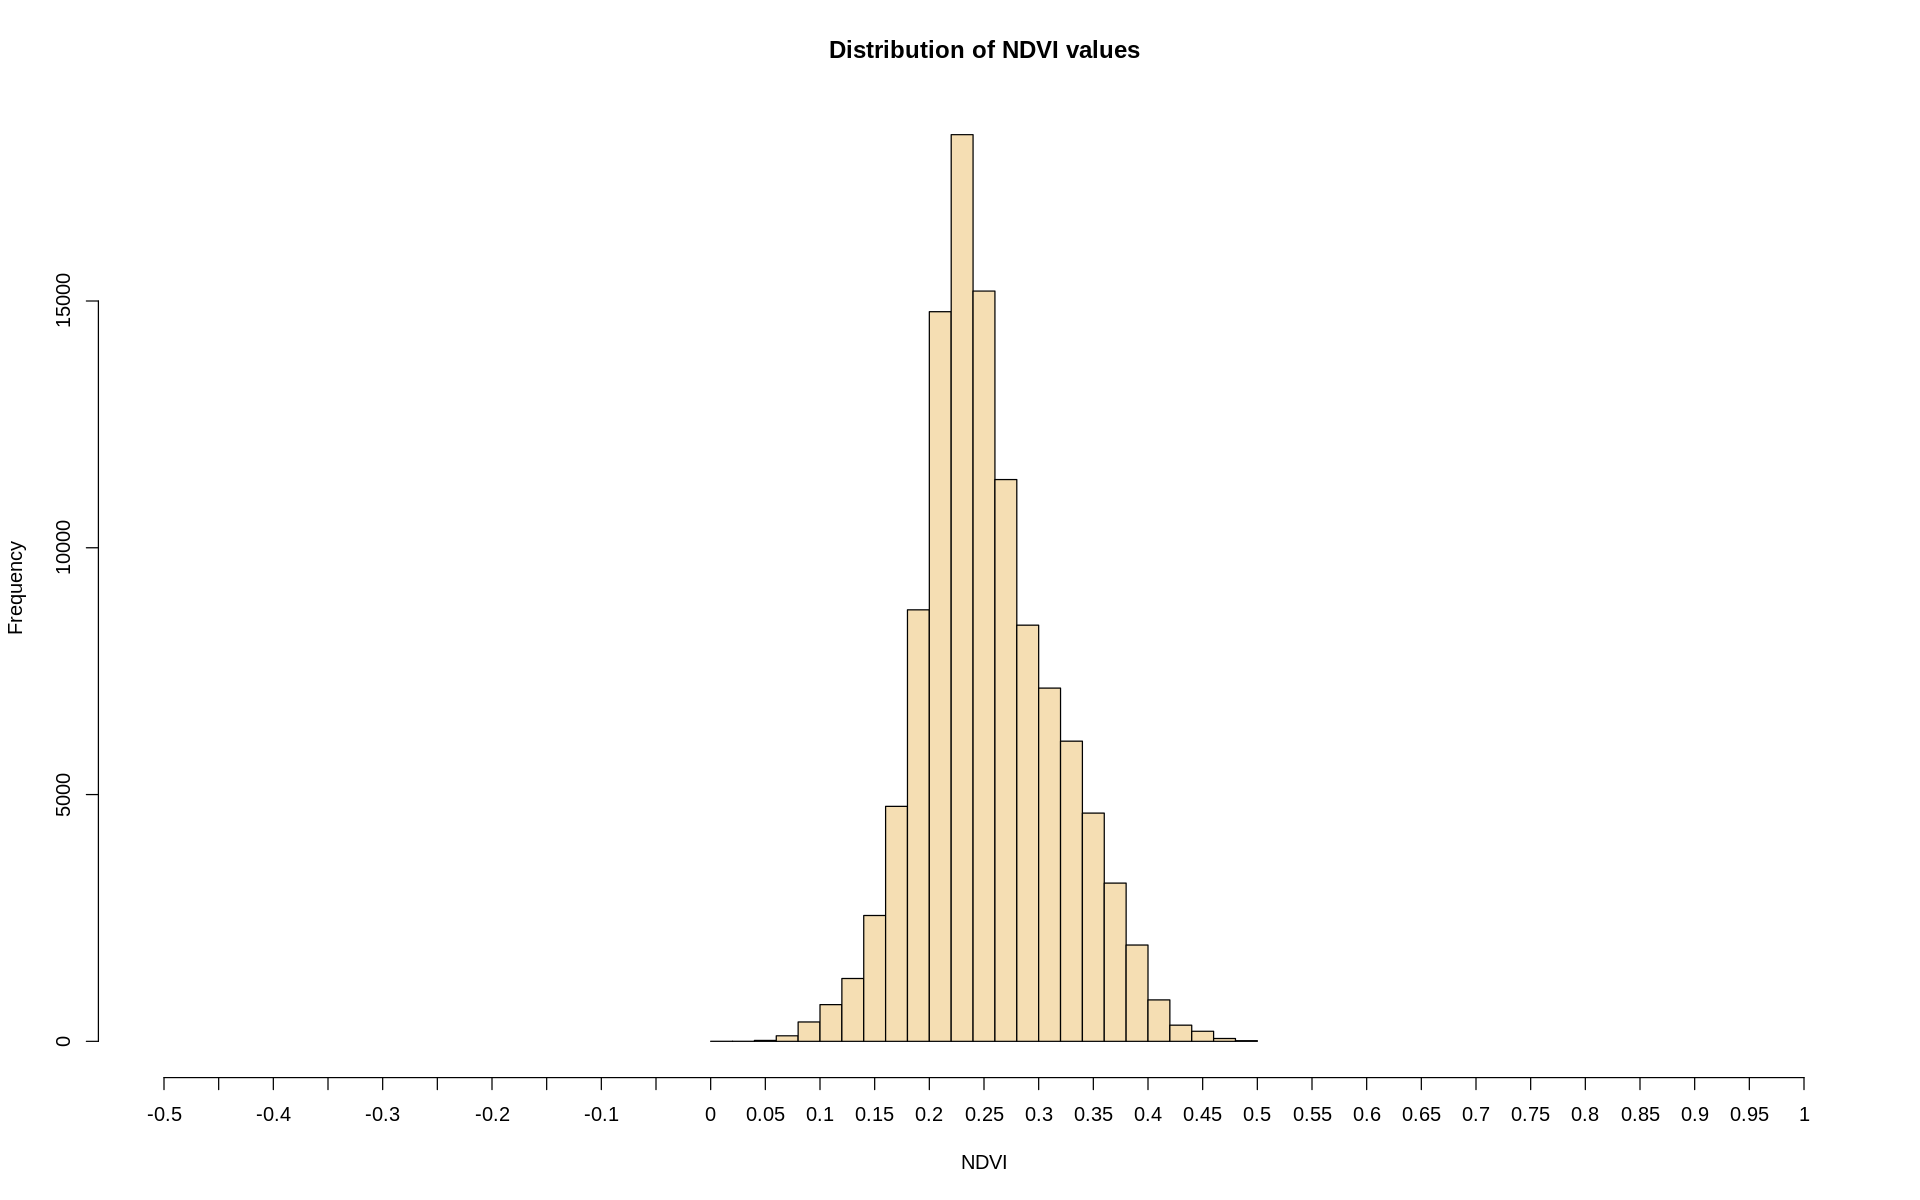

In [38]:
# View histogram
hist(ndvi,
     main = "Distribution of NDVI values",
     xlab = "NDVI",
     ylab= "Frequency",
     col = "wheat",
     xlim = c(-0.5, 1),
     breaks = 30,
     xaxt = 'n')
## Warning: [hist] 54% of the raster cells were used.
axis(side=1, at = seq(-0.5,1, 0.05), labels = seq(-0.5,1, 0.05))

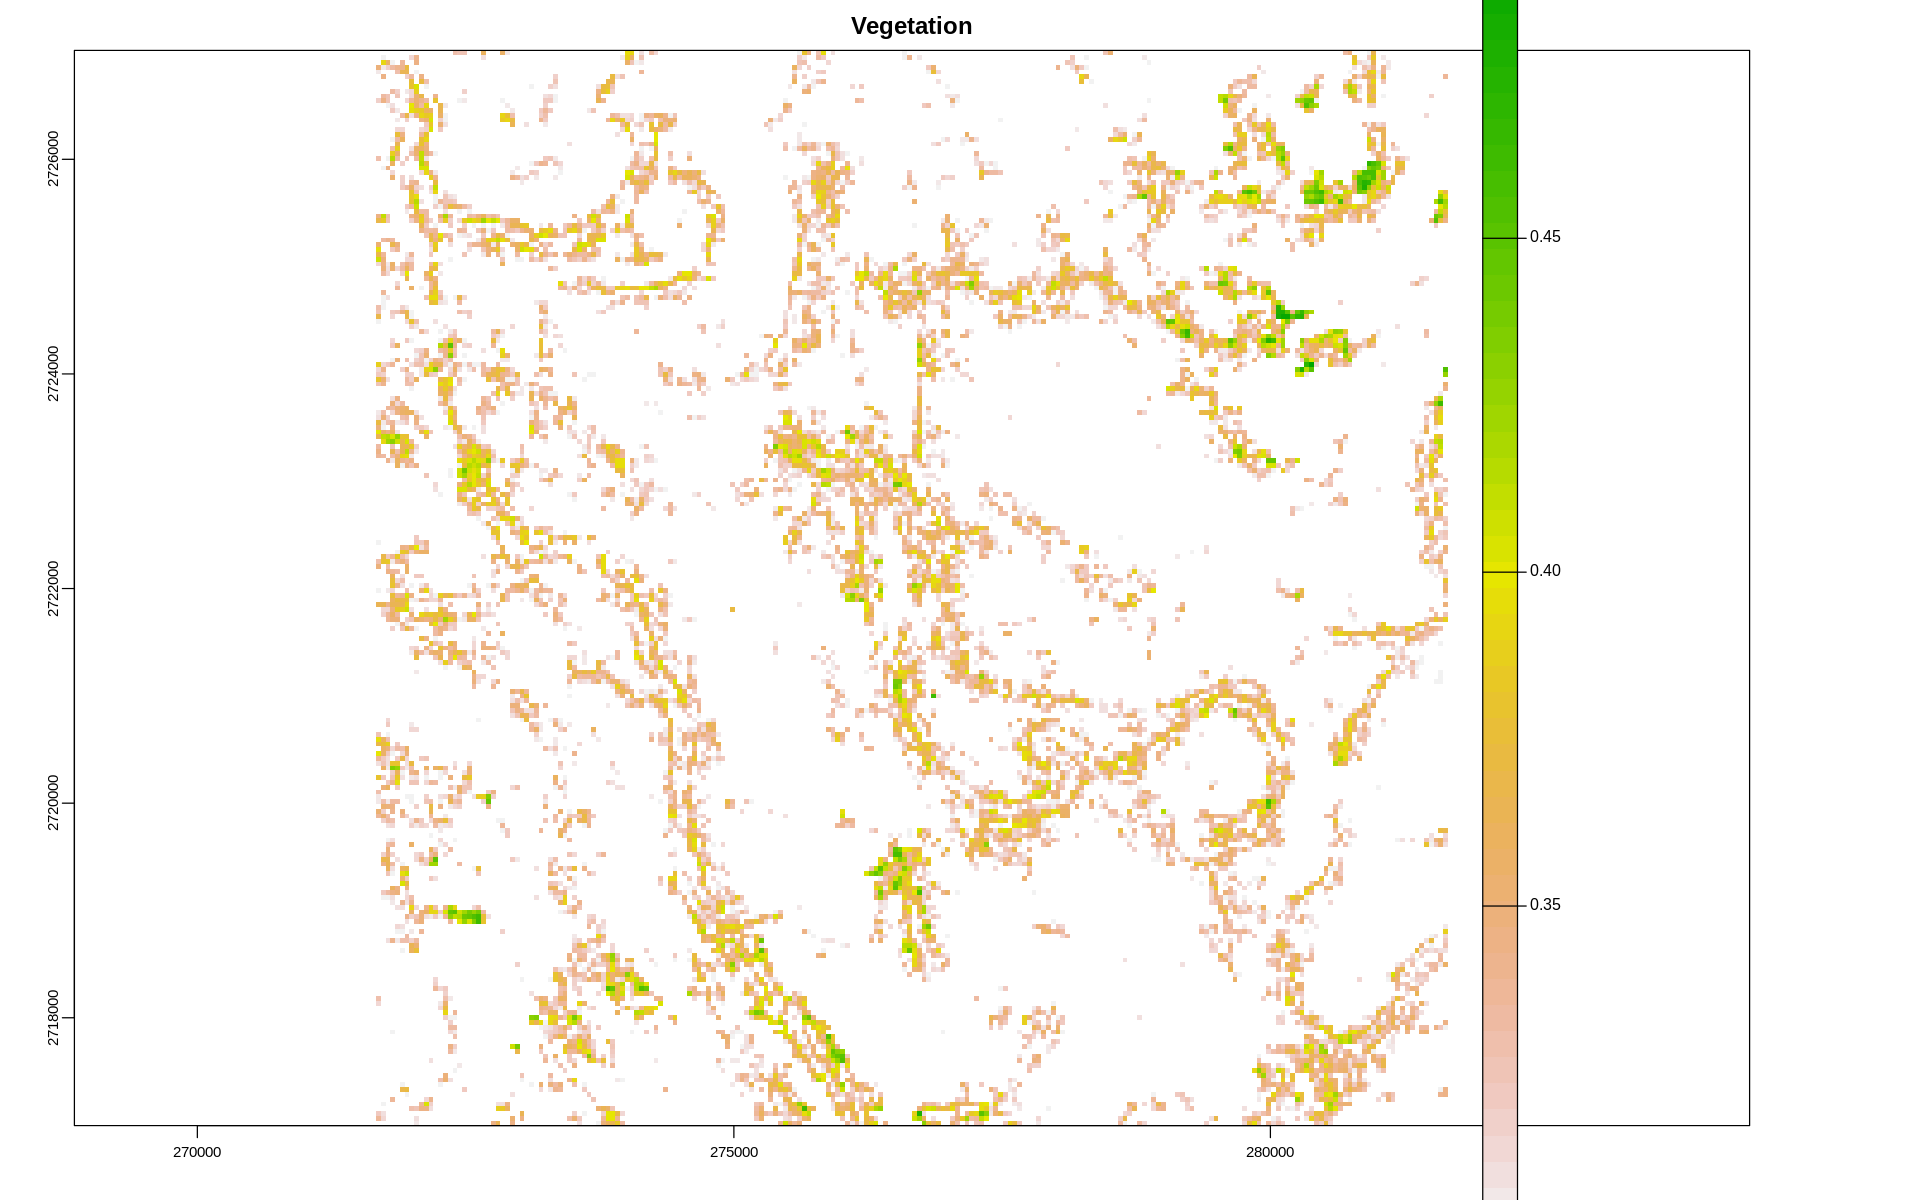

In [40]:
# Map specific vegetation
veg <- classify(ndvi, cbind(-Inf, 0.3, NA))
plot(veg, main='Vegetation')

     [,1] [,2] [,3]
[1,] -Inf 0.25    1
[2,] 0.25 0.30    2
[3,] 0.30 0.40    3
[4,] 0.40  Inf    4


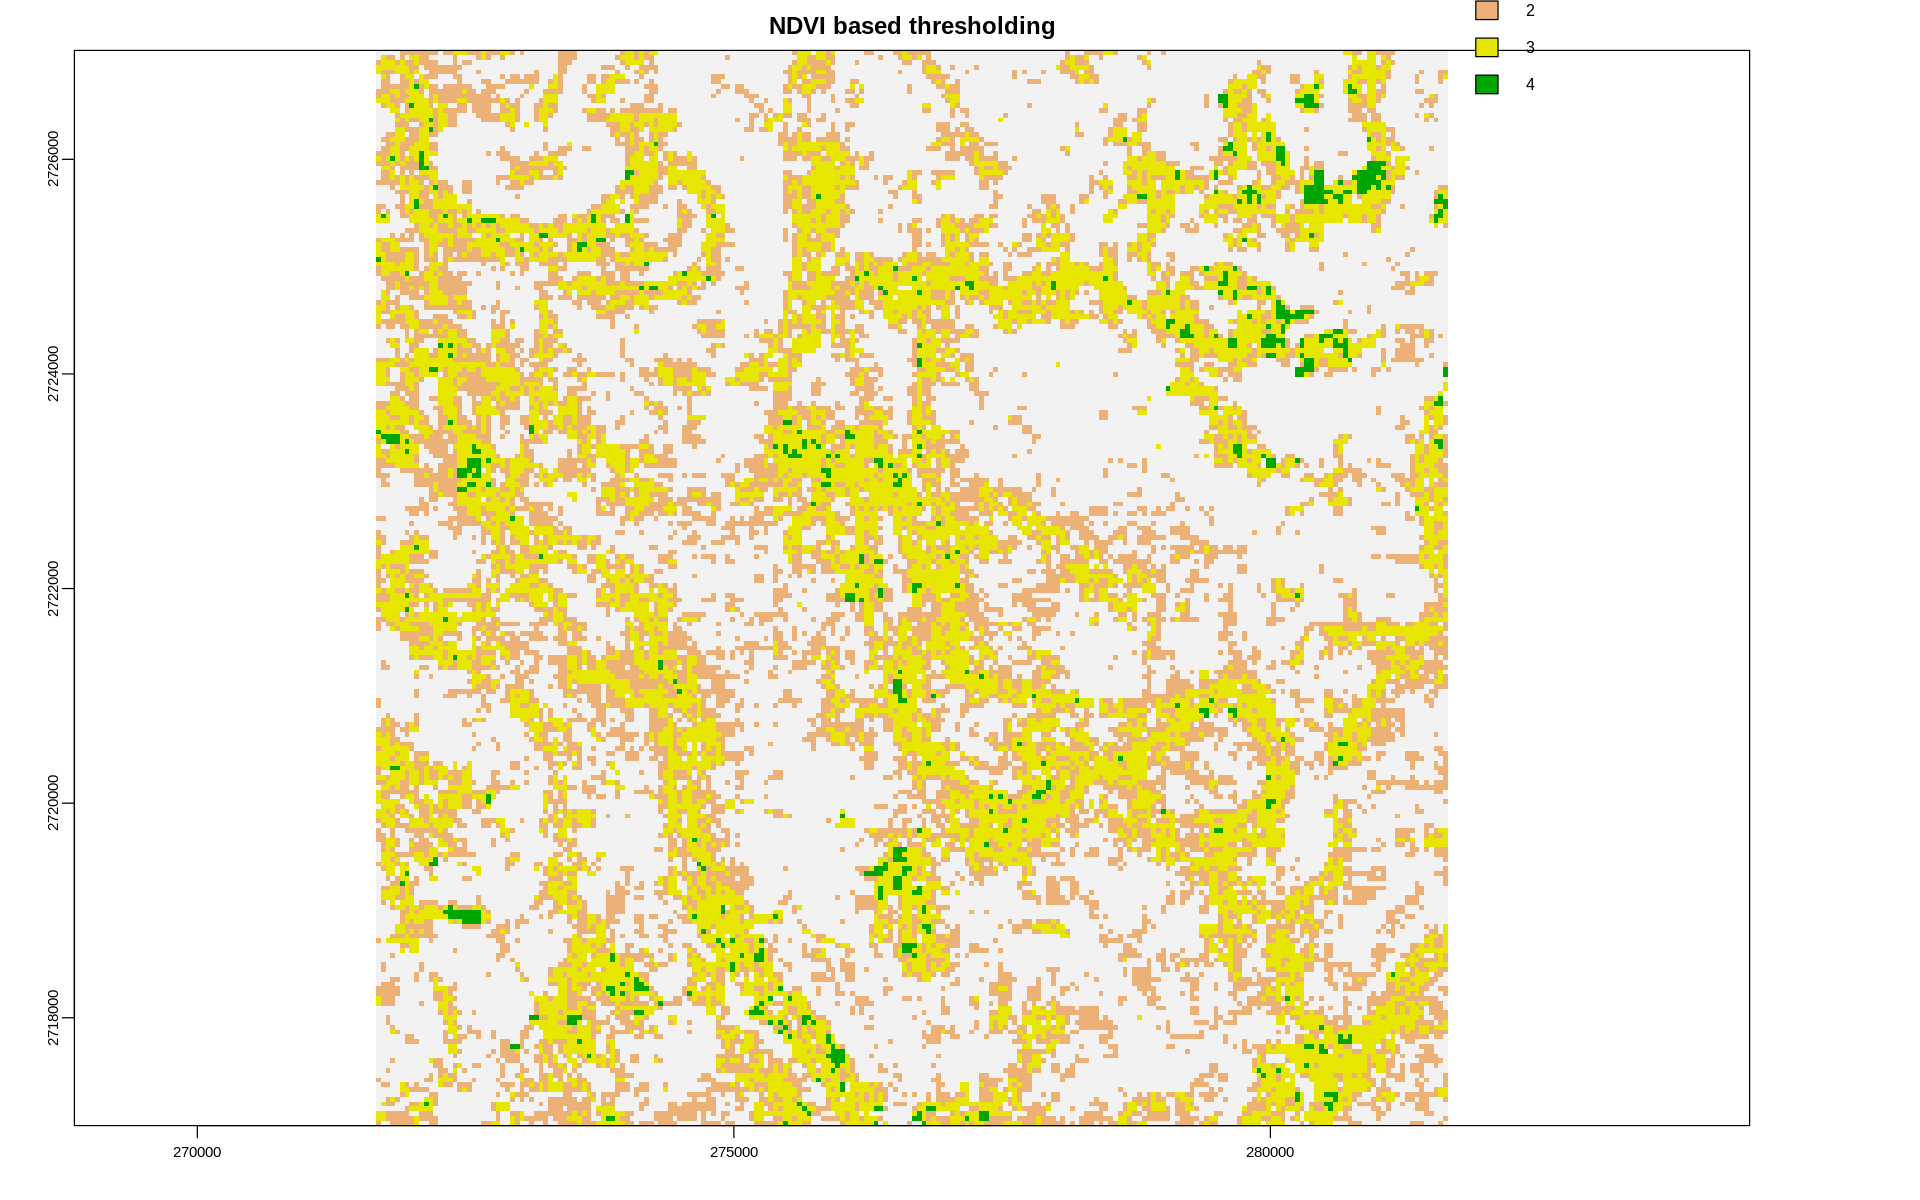

In [47]:
# or we can map multiple categories
m <- c(-Inf,0.25,1, 0.25,0.3,2, 0.3,0.4,3, 0.4,Inf,4)
rcl <- matrix(m, ncol = 3, byrow = TRUE)
print(rcl)
vegc <- classify(ndvi, rcl)
plot(vegc,col = rev(terrain.colors(4)), main = 'NDVI based thresholding')

In [51]:
# if we are interested to look at some spectral profiles
xy1 <- spatSample(rrs, size=10, method="regular", replace=FALSE, na.rm=TRUE)
head(xy1)

LC08_L1TP_137043_20190515_20190521_01_T1_B2
[1,] 11435                                      
[2,] 11535                                      
[3,] 11802                                      
[4,] 11552                                      
[5,] 11208                                      
[6,] 11376                                      
     LC08_L1TP_137043_20190515_20190521_01_T1_B3
[1,] 10674                                      
[2,] 10756                                      
[3,] 10959                                      
[4,] 10972                                      
[5,] 10306                                      
[6,] 10666                                      
     LC08_L1TP_137043_20190515_20190521_01_T1_B4
[1,]  9822                                      
[2,] 10061                                      
[3,] 10474                                      
[4,]  9568                                      
[5,]  9274                                      
[6,]  9895                                      
     LC08_L1TP_137043_20190515_20190521_01_T1_B5
[1,] 17747                                      
[2,] 16628                                      
[3,] 14710                                      
[4,] 23849                                      
[5,] 15628                                      
[6,] 18246

In [58]:
# it could be experimental fields
e <- ext(rrs)
xy2 <- spatSample(e, 100, method="random", lonlat=TRUE)
head(xy2)

# extract values
df <- extract(rrs, xy2)
head(df)

2.717e+06 2.72702e+06


x        y      
[1,] 275164.1 2718688
[2,] 272403.2 2725574
[3,] 276743.4 2721223
[4,] 278327.2 2720380
[5,] 273777.5 2717434
[6,] 278489.4 2723370

LC08_L1TP_137043_20190515_20190521_01_T1_B2
1 11143                                      
2 11376                                      
3 11183                                      
4 11232                                      
5 11205                                      
6 11443                                      
  LC08_L1TP_137043_20190515_20190521_01_T1_B3
1 10295                                      
2 10862                                      
3 10423                                      
4 10374                                      
5 10390                                      
6 10590                                      
  LC08_L1TP_137043_20190515_20190521_01_T1_B4
1  9212                                      
2  9742                                      
3  9271                                      
4  9327                                      
5  9697                                      
6 10020                                      
  LC08_L1TP_137043_20190515_20190521_01_T1_B5
1 15541                                      
2 20785                                      
3 18983                                      
4 15018                                      
5 14502                                      
6 15908

# Going at scale

Okay, these are nice. I understand next steps are getting some traning samples and produce classification maps. How about large scale remote sensing analysis? Can we streamline our workflow for large projects? 

In [59]:
# let's search and download some MODIS data
# we will use some luna functions to do that
prod <- getProducts()
head(prod)

provider   concept_id             short_name                         
1  GHRC       C1000-GHRC             dc8capac                           
5  CDDIS      C1000000000-CDDIS      CDDIS_DORIS_data_cycle             
18 LANCEAMSR2 C1000000000-LANCEAMSR2 A2_RainOcn_NRT                     
19 NSIDC_ECS  C1000000000-NSIDC_ECS  NmHRIR3H                           
23 ORNL_DAAC  C1000000000-ORNL_DAAC  GLOBAL_MICROBIAL_BIOMASS_C_N_P_1264
25 SEDAC      C1000000000-SEDAC      CIESIN_SEDAC_EPI_2012              
   version
1  1      
5  1      
18 0      
19 1      
23 1      
25 2012.00

In [60]:
# search for MODIS products
modis <- getProducts("^MOD|^MYD|^MCD")
head(modis)

provider   concept_id             short_name version
806  LPDAAC_ECS C1000000120-LPDAAC_ECS MOD44B     051    
1433 LPDAAC_ECS C1000000400-LPDAAC_ECS MCD43D10   006    
1447 LPDAAC_ECS C1000000401-LPDAAC_ECS MCD43D33   006    
1452 LPDAAC_ECS C1000000402-LPDAAC_ECS MCD43D45   006    
1454 LPDAAC_ECS C1000000403-LPDAAC_ECS MCD43D26   006    
1456 LPDAAC_ECS C1000000404-LPDAAC_ECS MCD43D49   006

In [72]:
# list the MODIS files
modproduct <- "MOD09A1"
mf <- getModis(modproduct, start_date=sdate, end_date=edate, aoi=area, download=FALSE, path=dir)
print(mf)

[1] "MOD09A1.A2019121.h26v06.006.2019130035047.hdf"
[2] "MOD09A1.A2019129.h26v06.006.2019150130313.hdf"
[3] "MOD09A1.A2019137.h26v06.006.2019150090157.hdf"
[4] "MOD09A1.A2019145.h26v06.006.2019154041621.hdf"


In [76]:
# setup the download
datadir <- file.path(getwd(), "_modis")
dir.create(datadir, showWarnings=TRUE) # make sure it worked
pwd <- "password"
user <- "user"
mf <- getModis(modproduct, start_date=sdate, end_date=edate, aoi=area, download=TRUE, path=datadir, username=user, password=pwd)

Warning message in dir.create(datadir, showWarnings = TRUE):
“'/home/jovyan/work/_modis' already exists”


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%



In [77]:
# list the downloaded files
mf <- list.files(datadir, pattern=".hdf$", full.names=TRUE)
mf

[1] "/home/jovyan/work/_modis/MOD09A1.A2019121.h26v06.006.2019130035047.hdf"
[2] "/home/jovyan/work/_modis/MOD09A1.A2019129.h26v06.006.2019150130313.hdf"
[3] "/home/jovyan/work/_modis/MOD09A1.A2019137.h26v06.006.2019150090157.hdf"
[4] "/home/jovyan/work/_modis/MOD09A1.A2019145.h26v06.006.2019154041621.hdf"

In [80]:
# read a single file
r <- rast(mf[1])
r

class       : SpatRaster 
dimensions  : 2400, 2400, 13  (nrow, ncol, nlyr)
resolution  : 463.3127, 463.3127  (x, y)
extent      : 8895604, 10007555, 2223901, 3335852  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +R=6371007.181 +units=m +no_defs 
sources     : MOD09A1.A2019121.h26v06.006.2019130035047.hdf:MOD_Grid_500m_Surface_Reflectance:sur_refl_b01  
              MOD09A1.A2019121.h26v06.006.2019130035047.hdf:MOD_Grid_500m_Surface_Reflectance:sur_refl_b02  
              MOD09A1.A2019121.h26v06.006.2019130035047.hdf:MOD_Grid_500m_Surface_Reflectance:sur_refl_b03  
              ... and 10 more source(s)
names       : MOD_G~l_b01, MOD_G~l_b02, MOD_G~l_b03, MOD_G~l_b04, MOD_G~l_b05, MOD_G~l_b06, ... 

In [81]:
# image properties
# dimension
nrow(r)
ncol(r)
# Number of layers (bands)
nlyr(r)
# resolution
res(r)
# projection
crs(r)
# names
names(r)

[1] 2400

[1] 2400

[1] 13

[1] 463.3127 463.3127

[1] "PROJCRS[\"unnamed\",\n    BASEGEOGCRS[\"Unknown datum based upon the custom spheroid\",\n        DATUM[\"Not specified (based on custom spheroid)\",\n            ELLIPSOID[\"Custom spheroid\",6371007.181,0,\n                LENGTHUNIT[\"metre\",1,\n                    ID[\"EPSG\",9001]]]],\n        PRIMEM[\"Greenwich\",0,\n            ANGLEUNIT[\"degree\",0.0174532925199433,\n                ID[\"EPSG\",9122]]]],\n    CONVERSION[\"unnamed\",\n        METHOD[\"Sinusoidal\"],\n        PARAMETER[\"Longitude of natural origin\",0,\n            ANGLEUNIT[\"degree\",0.0174532925199433],\n            ID[\"EPSG\",8802]],\n        PARAMETER[\"False easting\",0,\n            LENGTHUNIT[\"Meter\",1],\n            ID[\"EPSG\",8806]],\n        PARAMETER[\"False northing\",0,\n            LENGTHUNIT[\"Meter\",1],\n            ID[\"EPSG\",8807]]],\n    CS[Cartesian,2],\n        AXIS[\"easting\",east,\n            ORDER[1],\n            LENGTHUNIT[\"Meter\",1]],\n        AXIS[\"northing\",north,\n            ORDER[2],\n            LENGTHUNIT[\"Meter\",1]]]"

[1] "MOD_Grid_500m_Surface_Reflectance:sur_refl_b01"        
 [2] "MOD_Grid_500m_Surface_Reflectance:sur_refl_b02"        
 [3] "MOD_Grid_500m_Surface_Reflectance:sur_refl_b03"        
 [4] "MOD_Grid_500m_Surface_Reflectance:sur_refl_b04"        
 [5] "MOD_Grid_500m_Surface_Reflectance:sur_refl_b05"        
 [6] "MOD_Grid_500m_Surface_Reflectance:sur_refl_b06"        
 [7] "MOD_Grid_500m_Surface_Reflectance:sur_refl_b07"        
 [8] "MOD_Grid_500m_Surface_Reflectance:sur_refl_qc_500m"    
 [9] "MOD_Grid_500m_Surface_Reflectance:sur_refl_szen"       
[10] "MOD_Grid_500m_Surface_Reflectance:sur_refl_vzen"       
[11] "MOD_Grid_500m_Surface_Reflectance:sur_refl_raz"        
[12] "MOD_Grid_500m_Surface_Reflectance:sur_refl_state_500m" 
[13] "MOD_Grid_500m_Surface_Reflectance:sur_refl_day_of_year"

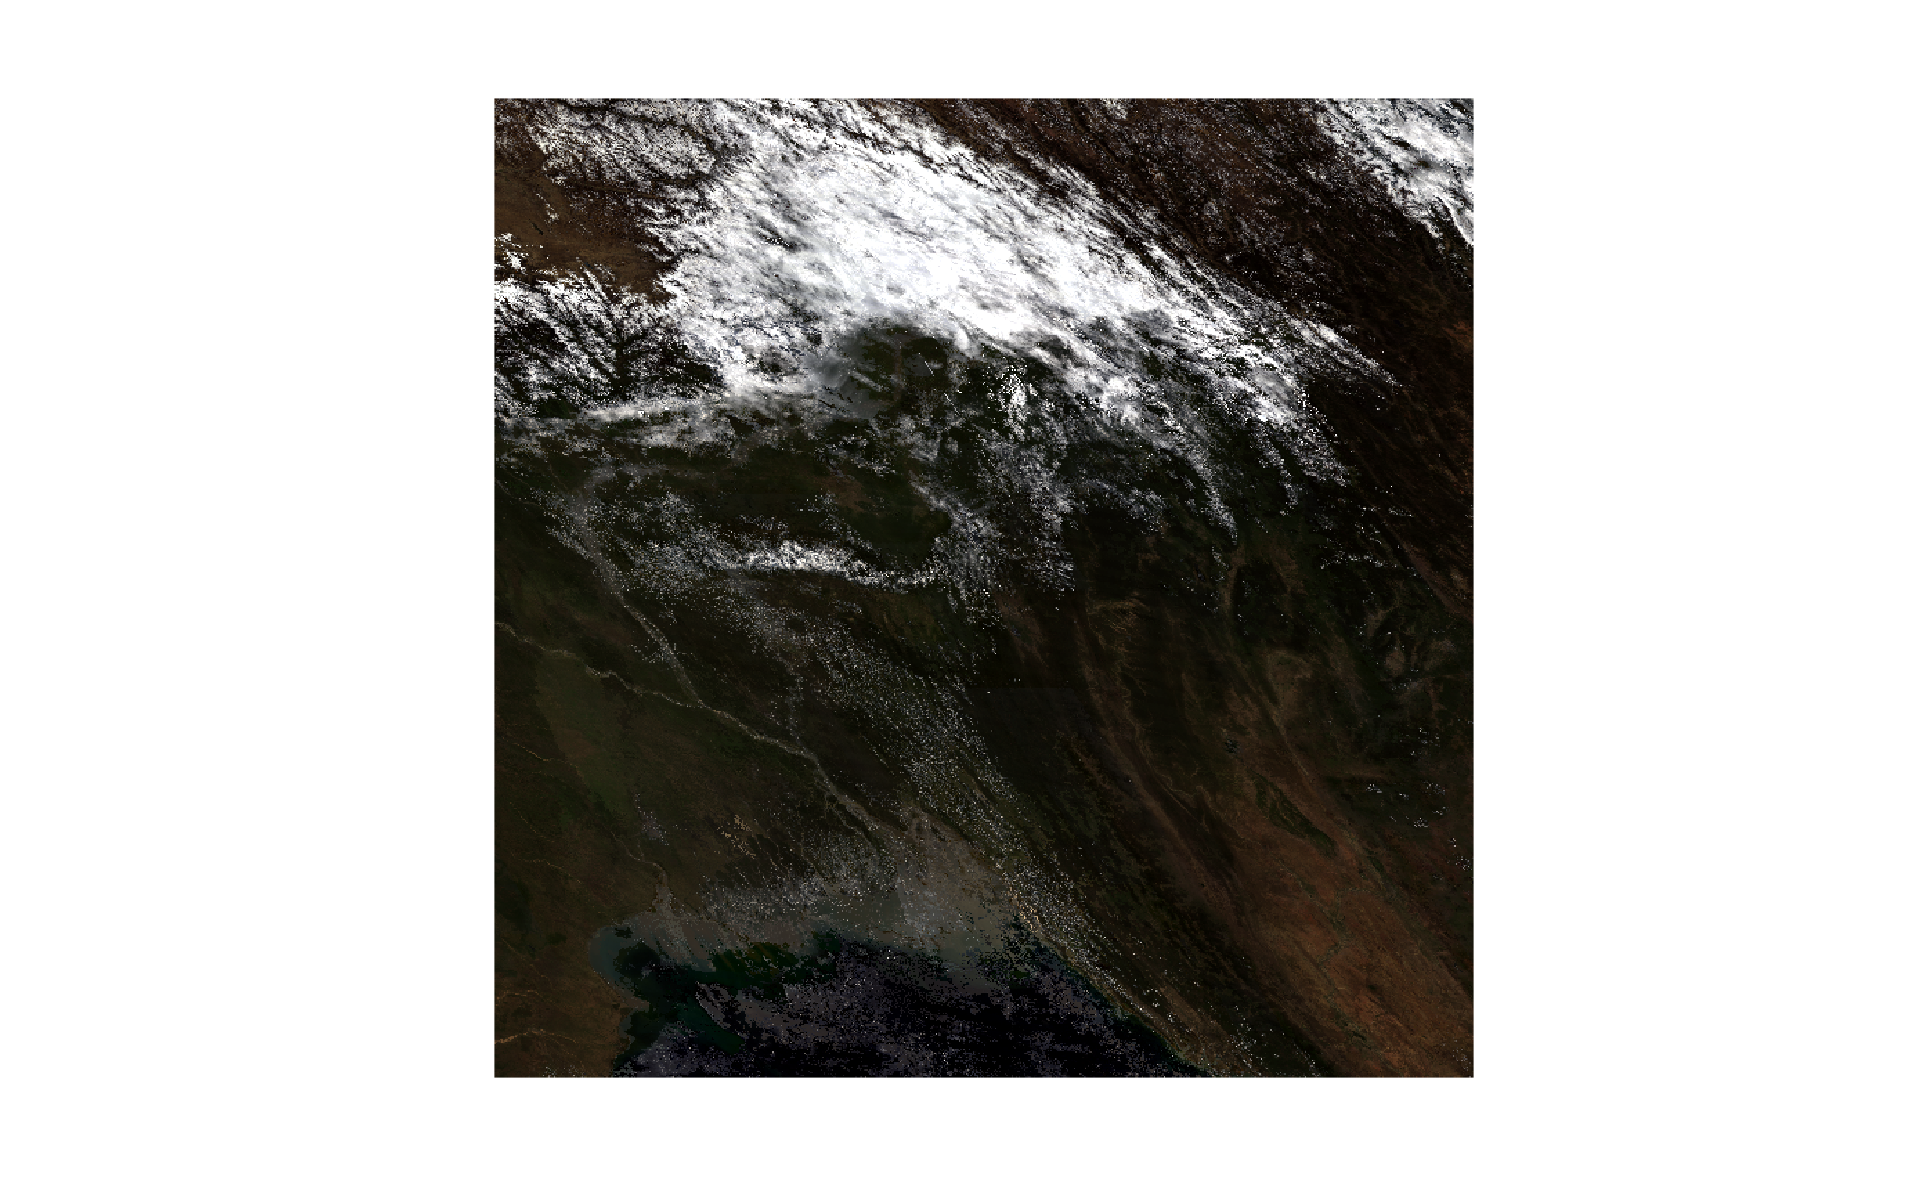

In [82]:
plotRGB(r, r = 1, g = 4, b = 3, stretch="lin")